## FRAUD DETECTION - EXPLORATORY DATA ANALYSIS

**Introduction**: The dataset contains transactions made by credit cards in September 2013 by European cardholders.
This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-sensitive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

Given the class imbalance ratio, performance of models are measured by recall, precision, the Area Under the ROC Curve (AUC_ROC)and the Area Under the PR Curve (AUC_PR).



## 1. Preparation

### Importing Libraries

In [0]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline 
from pyspark.sql import functions as f
from pyspark.sql.types import FloatType

from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler, StandardScaler, IndexToString, StringIndexer, VectorIndexer
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.classification import RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml import Pipeline
from pyspark.sql.functions import col,sum

import warnings
warnings.filterwarnings("ignore")

### Importing Data

In [0]:
# deading data
df = spark.table("workspace.default.creditcard")

# show first 5 rows of the data
display(df.head(5))


## 2. Exploratory Data Analysis

**2.1 Data Dimension**

In [0]:
# Checking the number of rows and columns
print(f"The dimension of the dataset is:  \n {df.count()} rows \n {len(df.columns)} columns")

The dimension of the dataset is:  
 284807 rows 
 31 columns


The dataset contains 284,807 rows and 31 columns, representing individual credit card transactions. The features include:

- **Time**: Seconds elapsed between each transaction and the first transaction in the dataset
- **V1-V28**: Twenty-eight anonymized features resulting from PCA transformation, likely applied for confidentiality reasons to protect sensitive cardholder information
- **Amount**: The transaction amount in USD
- **Class**: The target variable, a binary indicator where 0 represents non-fraudulent transactions and 1 represents fraudulent transactions

**Data preprocessing decisions:**

The Time feature will be removed from our analysis for the following reasons:
- The elapsed time since the first transaction does not provide meaningful information about fraud patterns
- Time-based features would be more valuable if represented as hour of day, day of week, or time since last transaction, which cannot be derived from the cumulative elapsed time
- Including Time in its current form could introduce noise without adding predictive value

Therefore, our modeling will focus on the 28 PCA-transformed features, the Amount variable, and the Class target variable, resulting in 29 features for analysis.

In [0]:
# drop Time column
df = df.drop("Time")
# Checking the summary statistics of the data
display(df.describe())

summary,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807,284807,284807,284807,284807,284807,284807,284807,284807,284807,284807,284807,284807,284807,284807,284807,284807,284807,284807,284807,284807,284807,284807,284807,284807,284807,284807,284807,284807,284807
mean,4.726190573349439E-16,4.981660334071031E-16,-4.7645110374576784E-15,2.6121783033782713E-15,1.0921332270848029E-15,1.7116473968346619E-15,-2.0405647137637107E-15,6.187158267476039E-17,-1.3794369150213112E-15,2.0025935247189587E-15,1.7691280929970198E-15,-1.6062661205370055E-15,9.524232016901826E-16,1.2070946194095189E-15,3.413714677642264E-15,1.4583730793692717E-15,-3.1933720090198914E-17,8.23889978327132E-16,9.703859192409195E-16,6.726039793998146E-16,-3.5725849350910035E-17,9.196911385977287E-16,3.999698441297414E-16,4.441182121544414E-15,1.210287991418539E-15,1.7134436685897354E-15,-3.384974329561085E-16,-1.1725662845619913E-16,88.34961925094701,0.001727485630620034
stddev,1.958695803857486,1.6513085794769975,1.516255005177772,1.4158685749409203,1.3802467340314397,1.3322710897575754,1.2370935981826658,1.1943529026692037,1.0986320892243193,1.088849765402517,1.0207130277115584,0.9992013895301445,0.9952742301251536,0.9585956112570637,0.9153160116104392,0.8762528873883704,0.8493370636743893,0.8381762095288414,0.8140405007685786,0.7709250248871167,0.7345240143713131,0.7257015604409116,0.6244602955949902,0.6056470678271599,0.5212780705409424,0.4822270132610573,0.40363249496503073,0.33008326416025086,250.1201092401885,0.04152718963546498
min,-56.407509631329,-72.7157275629303,-48.3255893623954,-5.68317119816995,-113.743306711146,-26.1605059358433,-43.5572415712451,-73.2167184552674,-13.4340663182301,-24.5882624372475,-4.79747346479757,-18.6837146333443,-5.79188120632084,-19.2143254902614,-4.49894467676621,-14.1298545174931,-25.1627993693248,-9.49874592104677,-7.21352743017759,-54.497720494566,-34.8303821448146,-10.933143697655,-44.8077352037913,-2.83662691870341,-10.2953970749851,-2.60455055280817,-22.5656793207827,-15.4300839055349,0.0,0
max,2.45492999121121,22.0577289904909,9.38255843282114,16.8753440335975,34.8016658766686,73.3016255459646,120.589493945238,20.0072083651213,15.5949946071278,23.7451361206545,12.0189131816199,7.8483920756446,7.12688295859376,10.5267660517847,8.87774159774277,17.3151115176278,9.25352625047285,5.04106918541184,5.59197142733558,39.4209042482199,27.2028391573154,10.5030900899454,22.5284116897749,4.58454913689817,7.51958867870916,3.5173456116238,31.6121981061363,33.8478078188831,25691.16,1


Since we will work in Python environment then it is more convenient to convert Spark table to Pandas dataframe for analysis.

In [0]:
df1=df.select("*").toPandas() # convert dataset to pandas for analysis with Python

**2.2 Check for missing values**  
There are no Nan values present in the dataset. It indicates that data is processed before releasing.

In [0]:
display(df1.isnull().sum().to_frame().T)


V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


**2.3 Data type**  
All feature are float64 data types except for target variable **class** which is integer.

In [0]:
df1.dtypes.to_frame().T

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64



**2.4 Feature Distributions**  

We observe that the features vary greatly in their value ranges, particularly the Amount variable which spans from near-zero to several thousand dollars, while the PCA-transformed features (V1-V28) vary between -50 to 50. This discrepancy in scale necessitates preprocessing before modeling.

**Why standardization is important:**
- **Scale sensitivity**: Many machine learning algorithms (e.g., logistic regression, SVM, neural networks, KNN) are sensitive to feature scales and may give disproportionate weight to features with larger ranges
- **Gradient descent optimization**: Features on different scales can cause slower convergence and unstable training in algorithms that use gradient-based optimization
- **Distance-based metrics**: Algorithms that rely on distance calculations (e.g., KNN, clustering) can be dominated by high-magnitude features

**Preprocessing strategy:**
This ensure all features are on a comparable scale and enable the model to learn patterns based on the actual importance of features rather than their numeric ranges, ultimately improving model performance and interpretability.

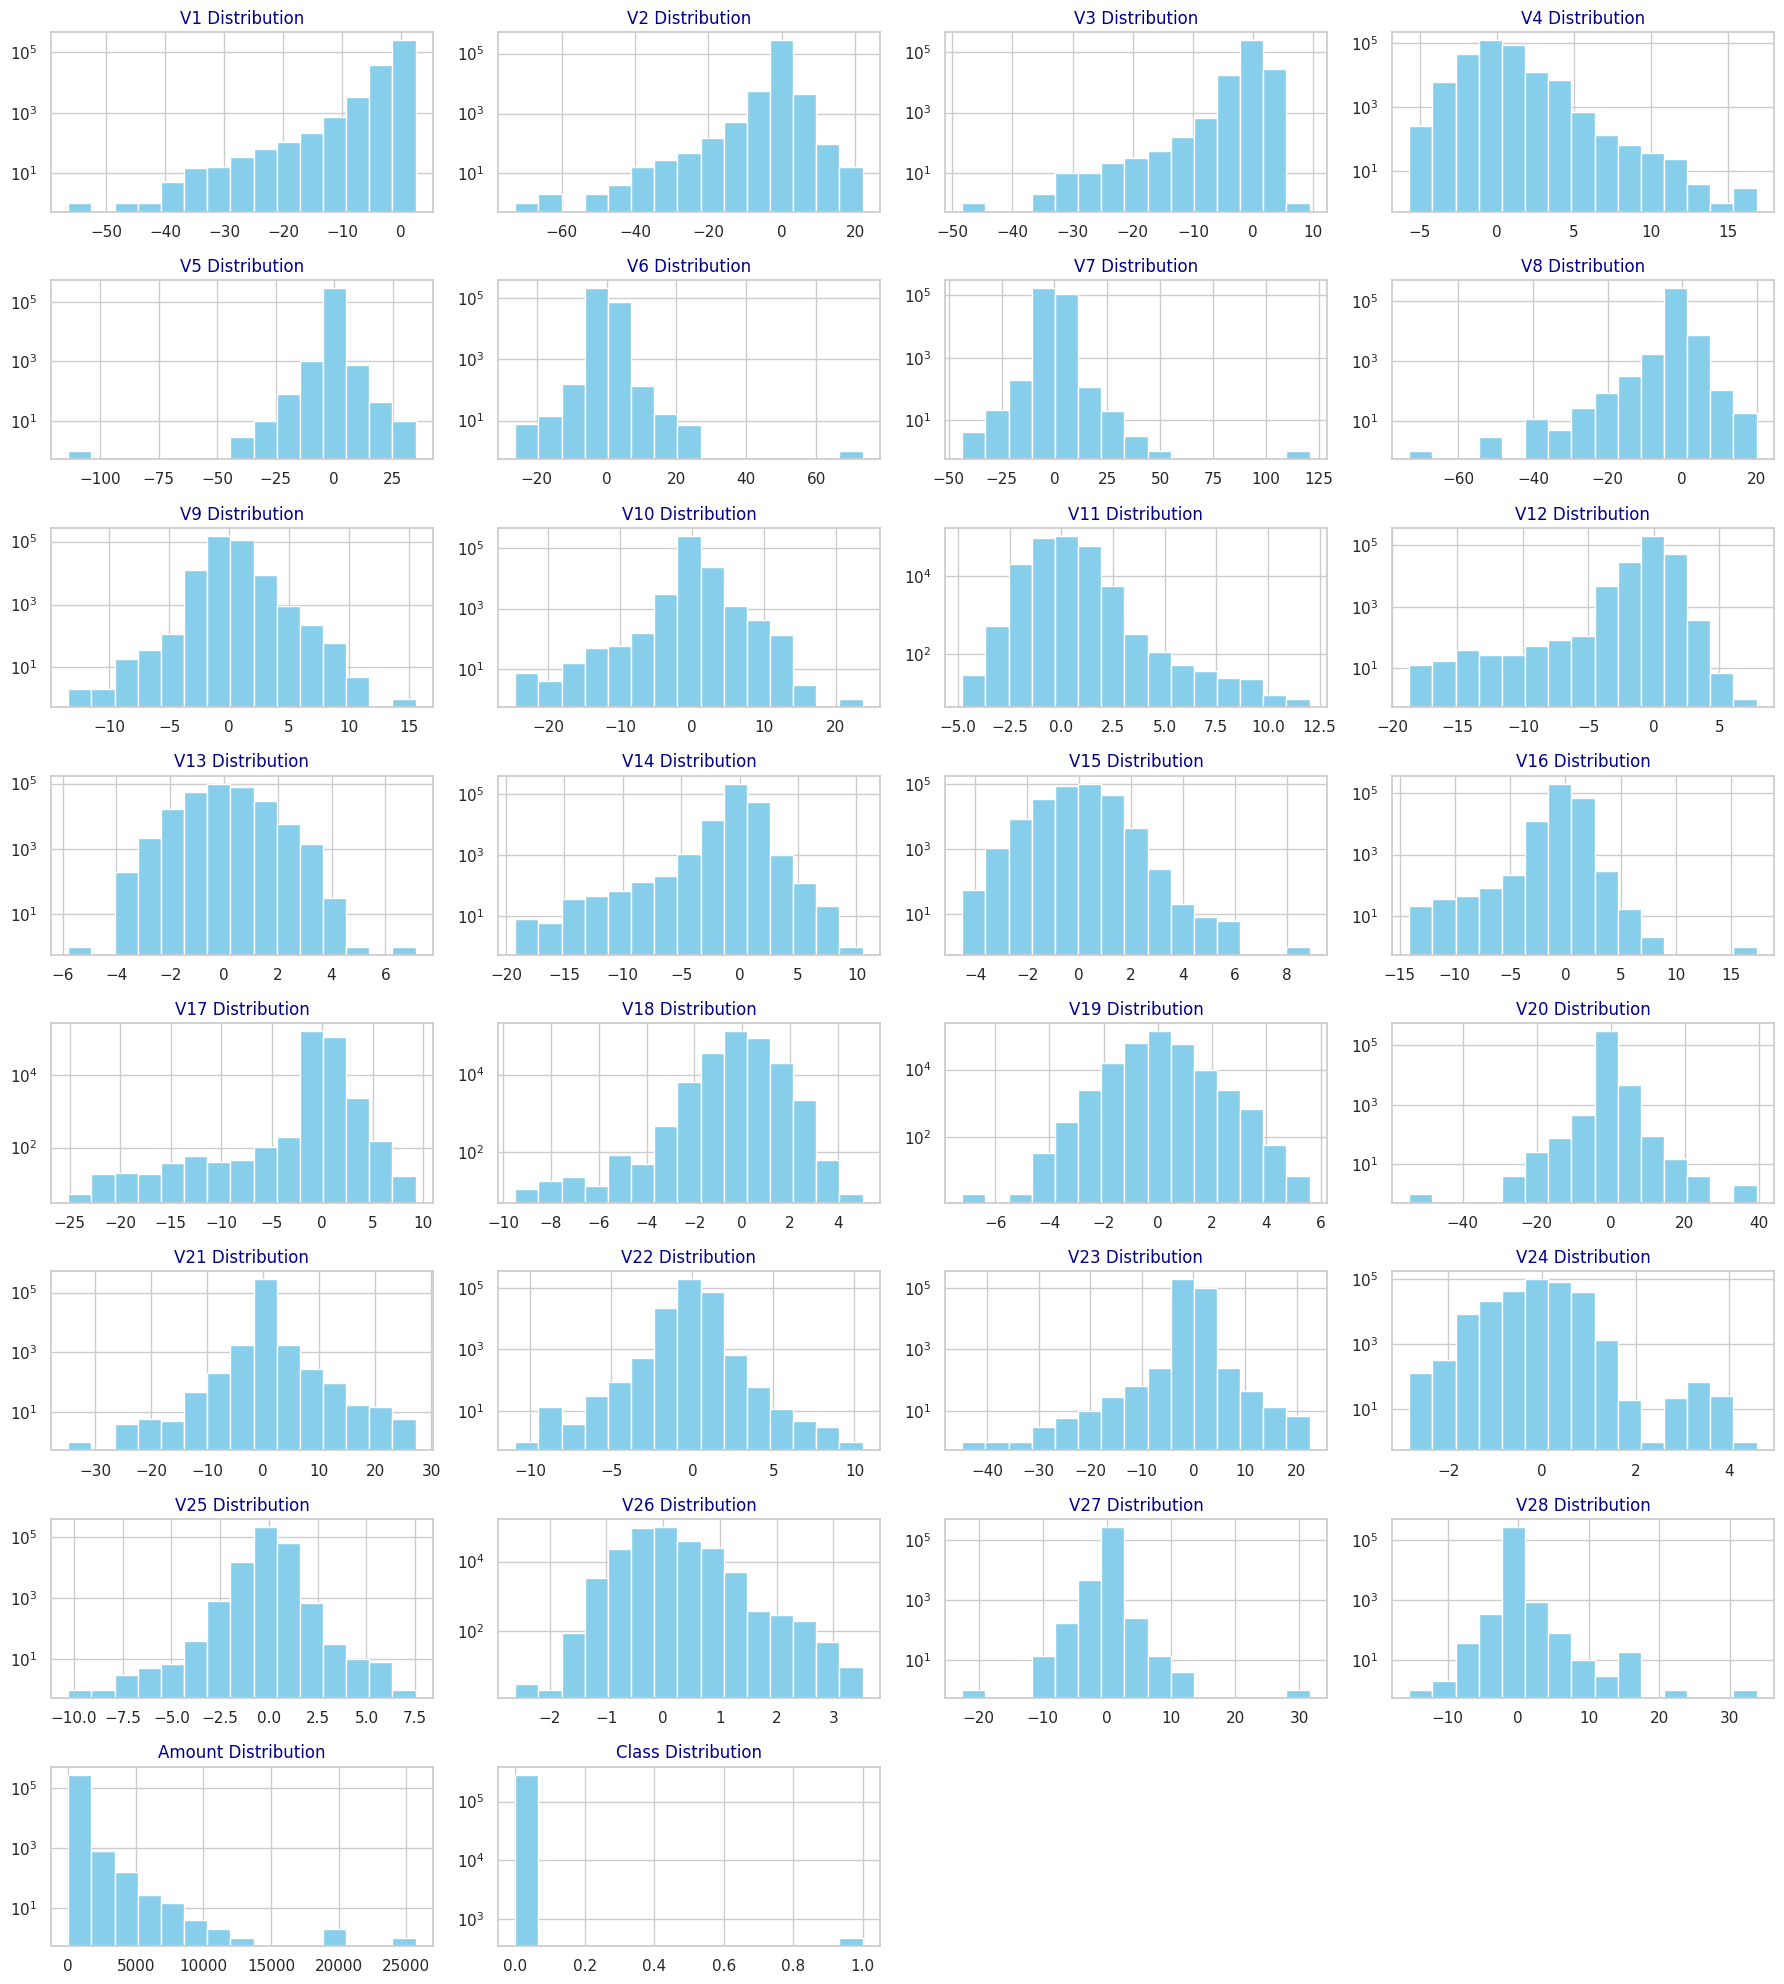

In [0]:
def draw_histograms(dataframe, features, rows, cols):
    
    fig=plt.figure(figsize=(18,20))
    for i, feature in enumerate(features):
        ax=fig.add_subplot(rows,cols,i+1)
        dataframe[feature].hist(bins=15,ax=ax,facecolor='skyblue')
        ax.set_title(feature+" Distribution",color='DarkBlue')
        ax.set_yscale('log')
    fig.tight_layout()  
    plt.show()
draw_histograms(df1,df1.columns,8,4)

**2.5 Feature Density Plot**

- **Amount variable**: Shows a right-skewed distribution with numerous outliers in the higher value range, indicating that most transactions are small while a few involve significantly larger amounts

- **PCA-transformed features (V1-V28)**: Display relatively normalized distributions with fewer extreme outliers, as expected from standardized data

<Figure size 640x480 with 0 Axes>

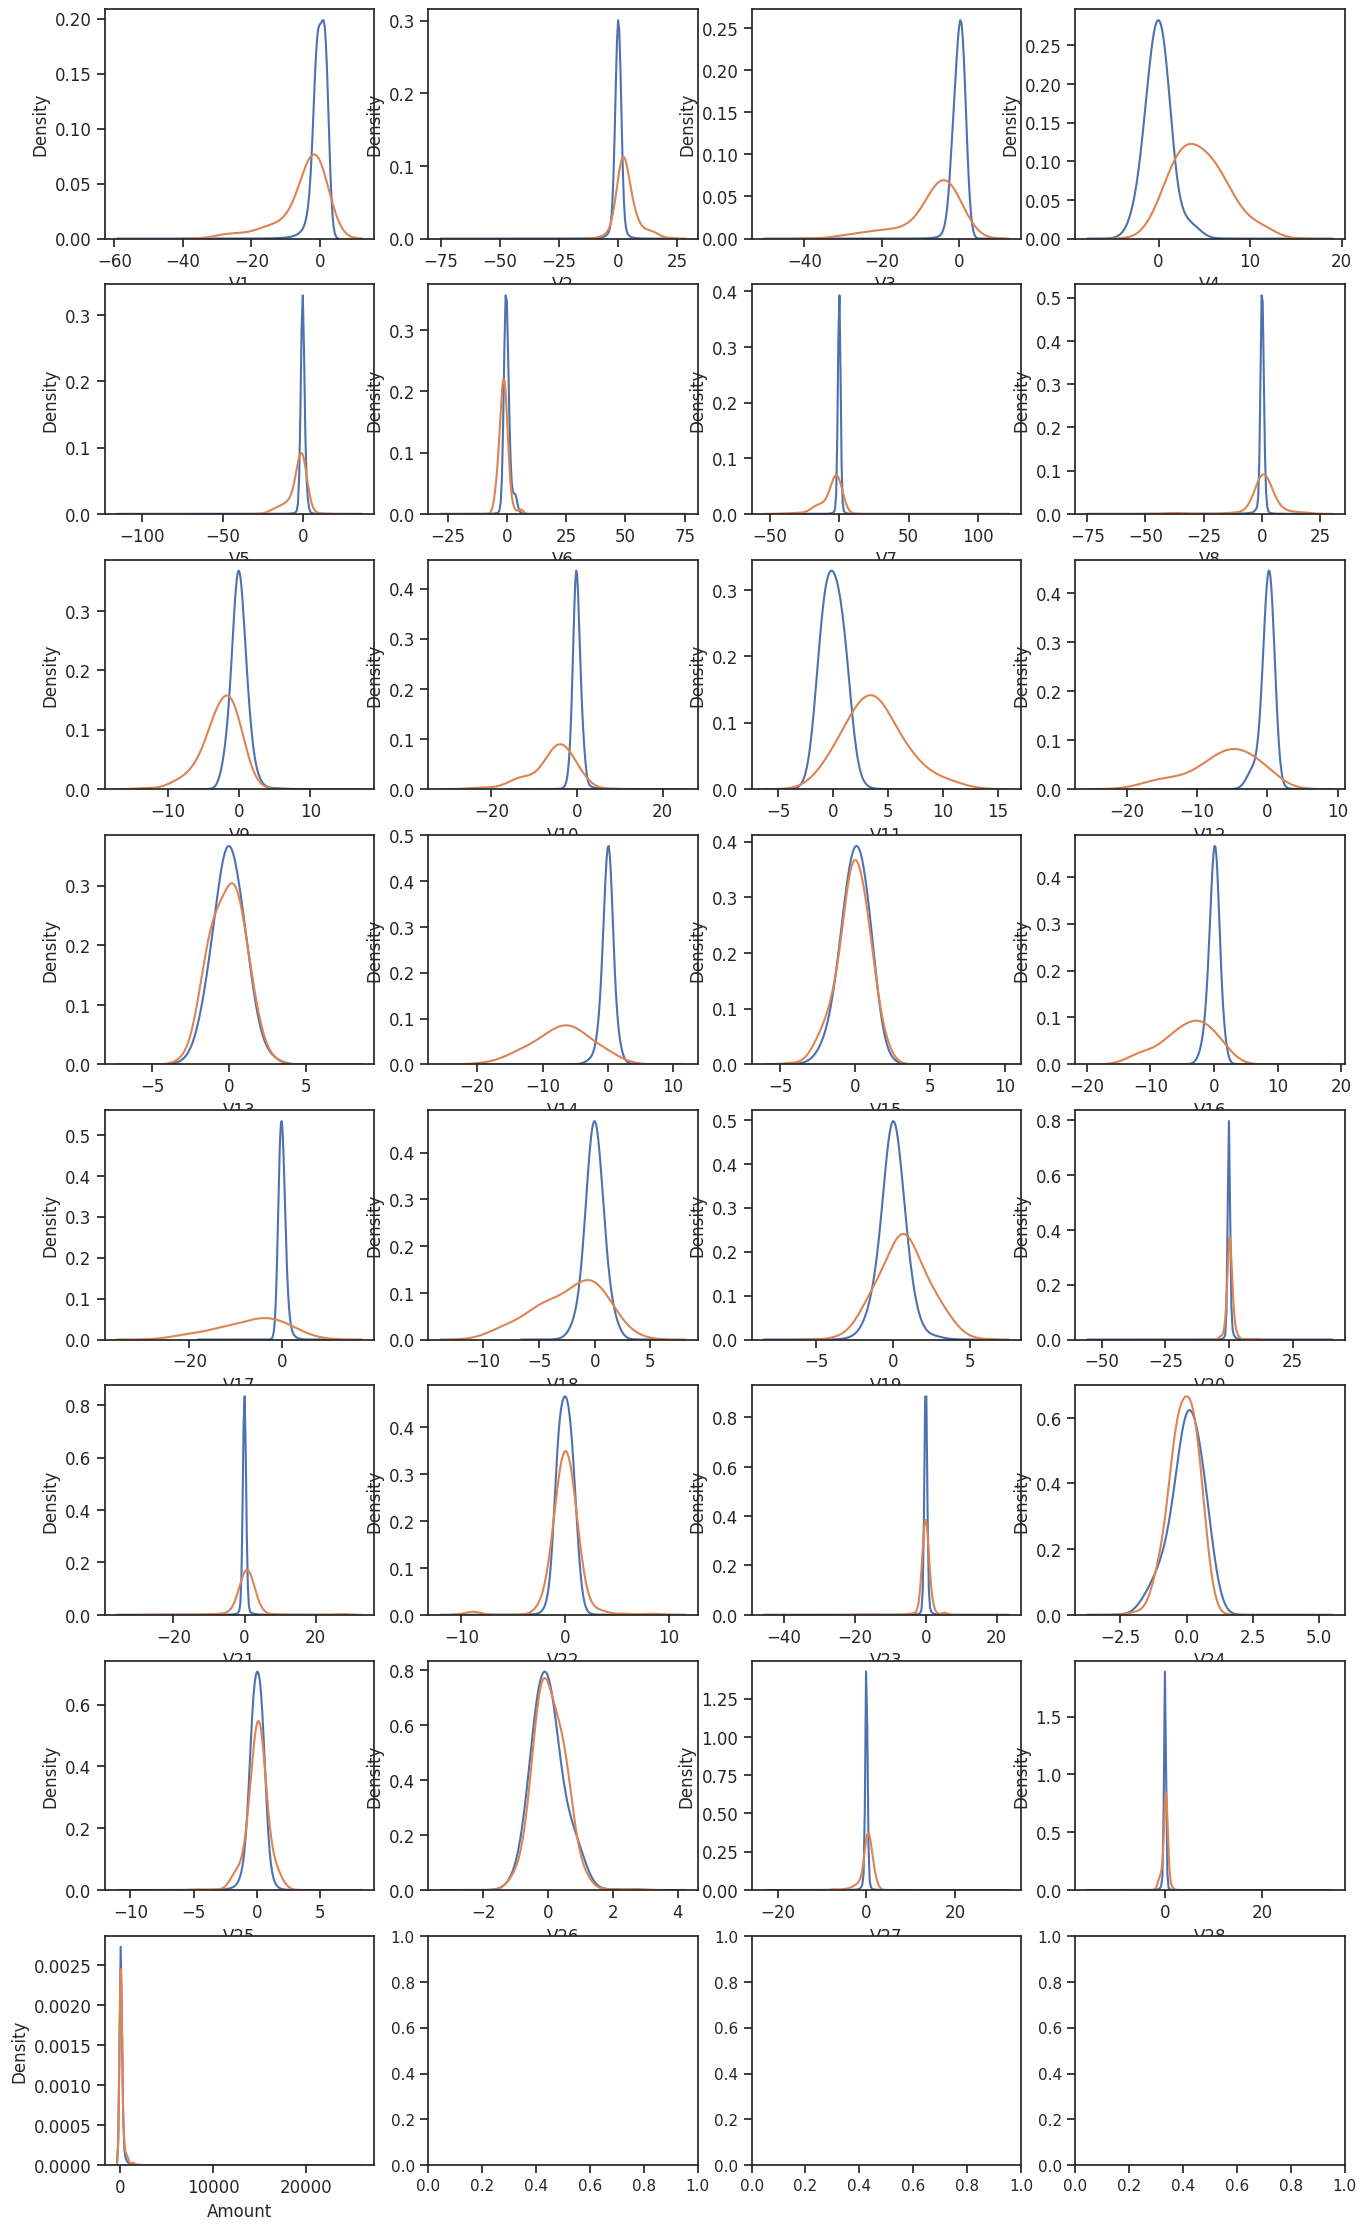

In [0]:
variables = [col for col in df1.columns if col != 'Class']

i = 0
t0 = df1.loc[df1['Class'] == 0]
t1 = df1.loc[df1['Class'] == 1]

sns.set_style('ticks')
plt.figure()
fig, ax = plt.subplots(8,4,figsize=(16,28))

for dffeature in variables:
    i += 1
    plt.subplot(8,4,i)
    sns.kdeplot(t0[dffeature], bw_method=0.5,label="Class = 0")
    sns.kdeplot(t1[dffeature], bw_method=0.5,label="Class = 1")
    plt.xlabel(dffeature, fontsize=12)
    locs, labels = plt.xticks()
    plt.tick_params(axis='both', which='major', labelsize=12)
plt.show();

**2.7 Boxplot for outlier detection**  
The boxplots are useful for visualizing the distribution and identifying potential outliers in the data. The analysis reveals that the Amount and Class variables exhibit distinct characteristics compared to the other features, which have been standardized through PCA transformation.

Due to these distinct characteristics, the Amount and Class variables will be handled separately in subsequent analysis. The Amount variable may require additional preprocessing such as scaling or transformation, while Class serves as our target variable for model training and evaluation.


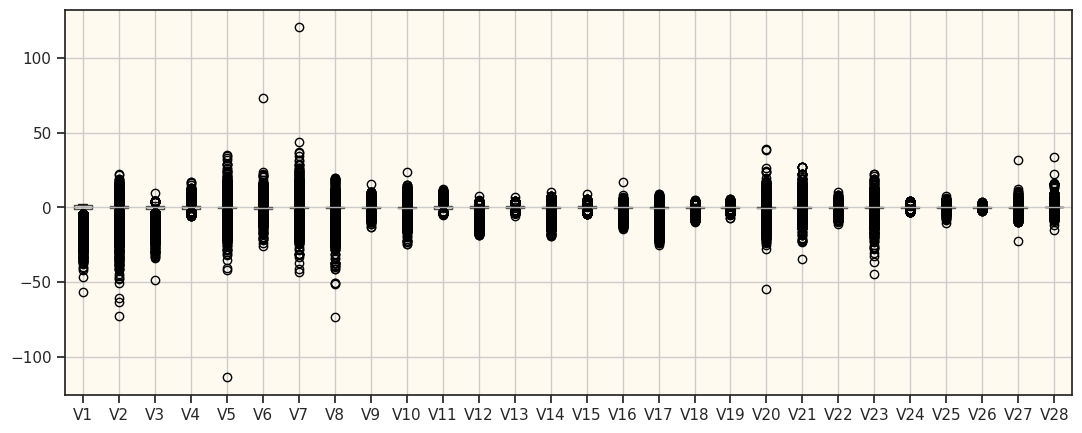

In [0]:
ax = df1.drop(['Amount','Class'],axis=1).boxplot(figsize=(13,5))
ax.set_facecolor('#fffaf0')  

**2.8 Correlation Matrix**  

The correlation matrix is useful for identifying potential collinearity between features, allowing us to apply appropriate techniques to address it before modeling. The results show near-zero correlation among features V1 through V28, which is expected since these features were derived from Principal Component Analysis (PCA) and are designed to be independent of each other. The **Amount** feature shows some correlation with V2, V5, V7, and V20, though these correlations are not significant. Similarly, the **Class** variable (target) shows minor correlations with V12, V14, and V17.



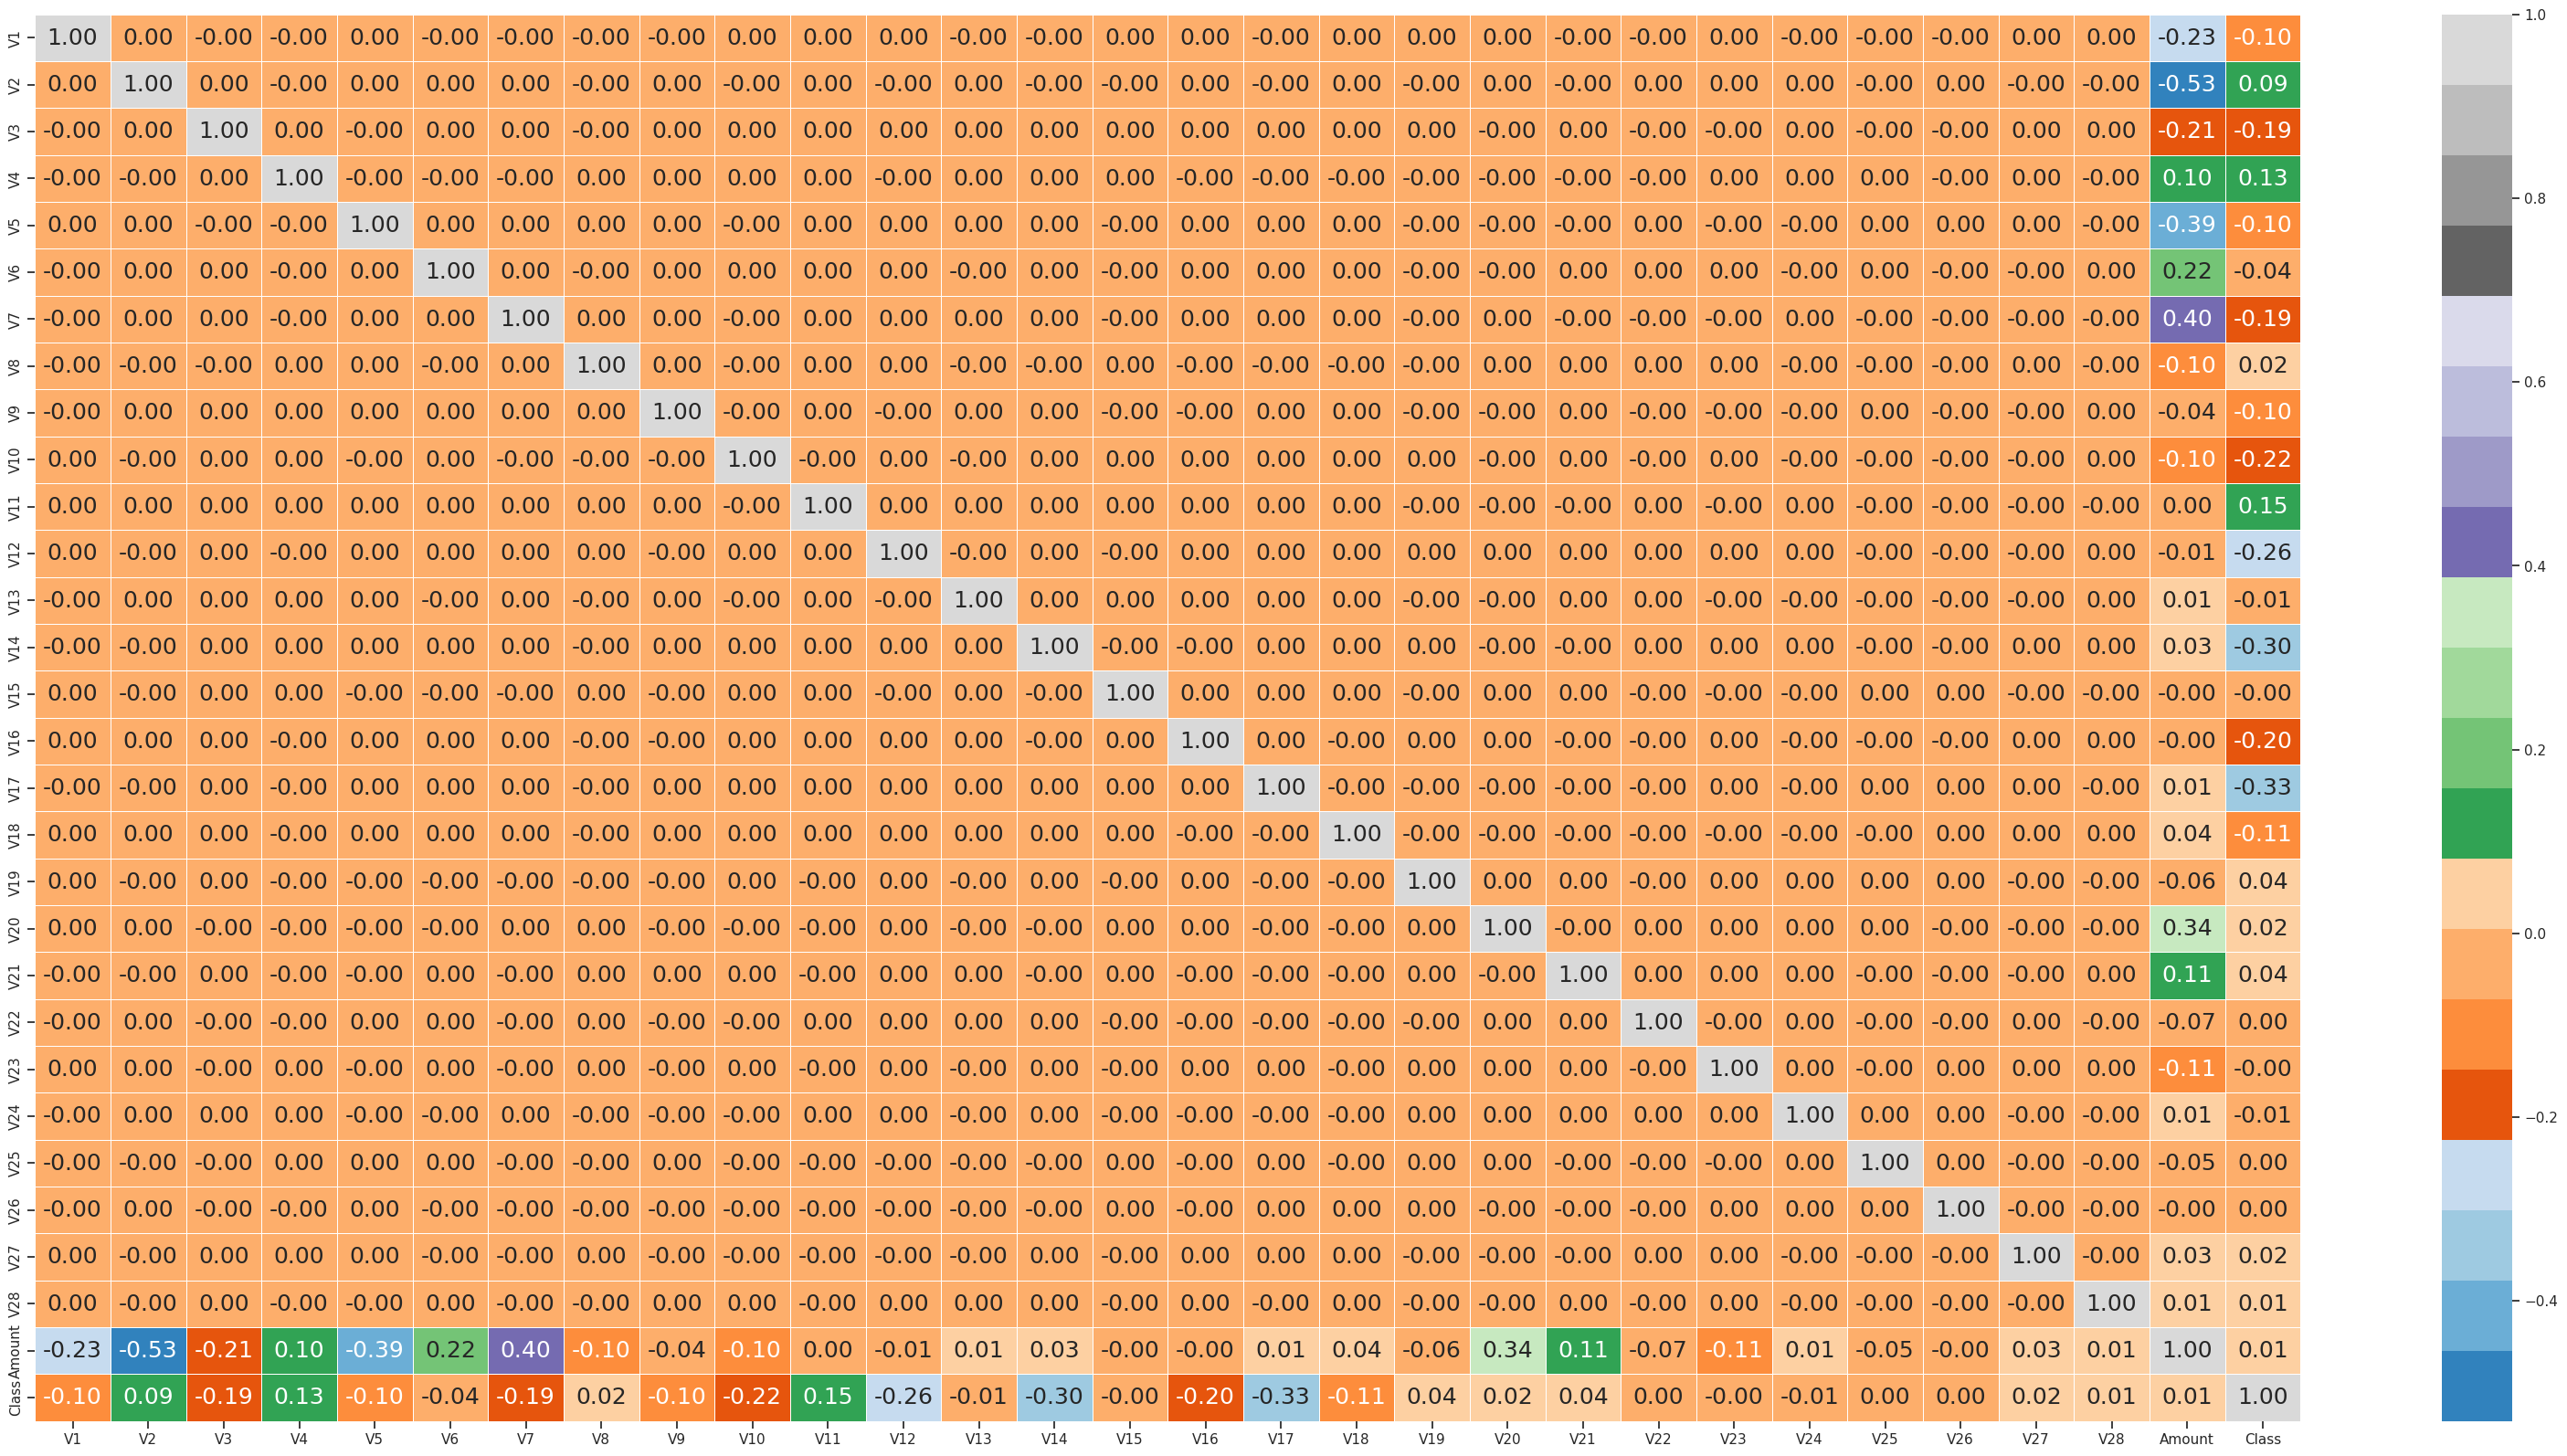

In [0]:
# generating correlation matrix

df_corr = df1.corr().round(3)

# Plot heatmap
plt.figure(figsize=(40, 20))
sns.heatmap(df_corr, annot=True, cmap="tab20c", fmt='.2f', annot_kws={"size": 18}, linecolor='white', linewidths=0.7)
plt.show()

**2.9 Target Variable Analysis**

Number of observations in each class group.

In [0]:
df.groupBy("Class").count().show()

+-----+------+
|Class| count|
+-----+------+
|    1|   492|
|    0|284315|
+-----+------+



**Visualize proportion of each class in target variable**

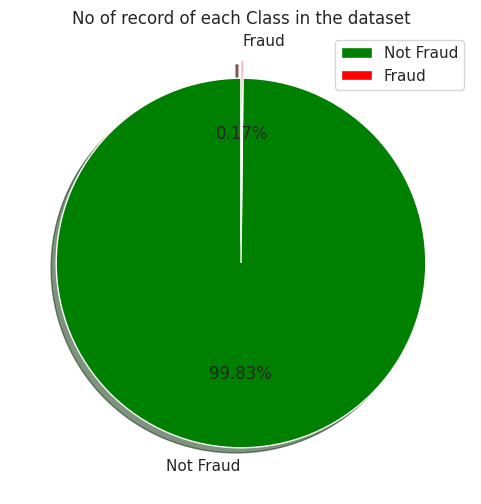

In [0]:
sns.set(style="whitegrid")
titles = ['Not Fraud', 'Fraud']
data = df1['Class'].value_counts(sort = True)

colors = ["Green","red"]
explode = (0,0.1) 
 
plt.figure(figsize=(6,6))
plt.pie(data, explode=explode, labels=titles, colors=colors, autopct='%1.2f%%', shadow=True, startangle=90,)

plt.title('No of record of each Class in the dataset')
plt.legend()
plt.show()

The graph shows that only 0.17% of transactions are fraudulent, while the remaining 99.83% are legitimate transactions. This indicates that our dataset is highly imbalanced, which needs to be taken into consideration during the modeling process.

**2.10 Dollar Amount of Fraudulent Transactions**

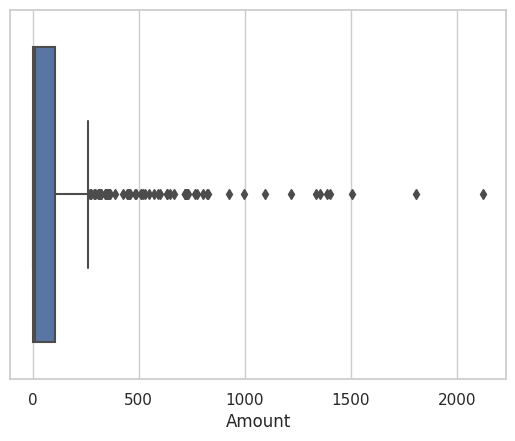

In [0]:
fraud = df1.loc[df1['Class'] == 1]
plt.tight_layout()
sns.boxplot(x=fraud['Amount'], data=fraud)
plt.show()

In [0]:
# maximum value of fraud amount
print('Maximum value of fraud amount',fraud['Amount'].max())

# 95% quantile of fraud amount
print('95% quantile of fraud amount',fraud['Amount'].quantile(.95))


Maximum value of fraud amount 2125.87
95% quantile of fraud amount 640.9049999999999


The analysis of fraudulent transaction amounts reveals interesting patterns. The maximum fraud amount is USD 2,125, while 95% of fraudulent transactions involve amounts below USD 641. This indicates that fraudsters predominantly target smaller transaction values, likely as a strategy to avoid detection systems that may flag unusually large or suspicious amounts.

This behavioral pattern has important implications for fraud detection:
- **Detection thresholds**: Rule-based systems that only flag high-value transactions may miss the majority of fraudulent activity
- **Feature engineering**: Transaction amount alone may not be a strong discriminator, requiring additional behavioral and contextual features
- **Risk assessment**: The cumulative impact of many small fraudulent transactions can still result in significant financial losses over time

Understanding this distribution helps inform both the feature selection process and the design of effective fraud prevention strategies that account for the prevalence of low-value fraudulent transactions.

The training dataset is highly imbalanced, with 99.83% non-fraudulent transactions and only 0.17% fraudulent transactions. This severe class imbalance poses a significant challenge for model training, as the model may become biased toward predicting the majority class (non-fraudulent) and fail to detect fraudulent transactions effectively.

To address this imbalance, we will employ techniques such as:
- **Resampling methods**: Oversampling the minority class (SMOTE) or undersampling the majority class
- **Class weights**: Adjusting the loss function to penalize misclassification of the minority class more heavily
- **Evaluation metrics**: Using precision, recall, F1-score, and AUC-ROC instead of accuracy, as accuracy can be misleading with imbalanced datasets.

In this project, we will go with oversampling the minority class method. This will be done in the next notebook.